In [33]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim import SGD, Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
from re import X
# 2. Create the dataset
X_train = torch.tensor([[[[1, 2, 3, 4], [2, 3, 4, 5], \
                          [5, 6, 7, 8], [1, 3, 4, 5]]], \
                        [[[-1, 2, 3, -4], [2, -3, 4, 5], \
                          [-5, 6, -7, 8], [-1, -3, -4, -5]]]]).to(device).float()

X_train /= 8
y_train = torch.tensor([0, 1]).to(device).float()

*Note that PyTorch expects inputs to be of the shape NxCxHxW, where N is the number (batch_size) of images, C is the number of channels, H is the height, and W is the width of the image.*

In [35]:
# 3. Define the model architecture

def get_model():
  model = nn.Sequential(
    nn.Conv2d(1, 1, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(1, 1),
    nn.Sigmoid(),
  ).to(device)

  loss_fn = nn.BCELoss()
  optimizer = Adam(model.parameters(), lr=0.001)

  return model, loss_fn, optimizer

In [36]:
# 4.Summarize the model architecture using summary() method of torchinfo
!pip install torch_summary
from torchsummary import summary
model, loss_fn, optimizer = get_model()


# Get summary
summary(model, X_train)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 1, 2, 2]             10
├─MaxPool2d: 1-2                         [-1, 1, 1, 1]             --
├─ReLU: 1-3                              [-1, 1, 1, 1]             --
├─Flatten: 1-4                           [-1, 1]                   --
├─Linear: 1-5                            [-1, 1]                   2
├─Sigmoid: 1-6                           [-1, 1]                   --
Total params: 12
Trainable params: 12
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 1, 2, 2]             10
├─MaxPool2d: 1-2                         [-1, 1, 1, 1]             --
├─ReLU: 1-3                              [-1, 1, 1, 1]             --
├─Flatten: 1-4                           [-1, 1]                   --
├─Linear: 1-5                            [-1, 1]                   2
├─Sigmoid: 1-6                           [-1, 1]                   --
Total params: 12
Trainable params: 12
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [37]:
# 5. Train the model

def train_batch(x, y, model, opt, loss_fn):
  model.train()
  # Forward pass
  prediction = model(x)

  # Calculate the loss
  batch_loss = loss_fn(prediction.squeeze(0), y)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss backward
  batch_loss.backward()

  # Optimizer step
  optimizer.step()

  return batch_loss.item()


### Define the training DataLoader

trn_dl = DataLoader(TensorDataset(X_train, y_train))

### Train the model for over 2,000 epochs
for epoch in range(2000):
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)

In [38]:
# 6. Perform a forward pass on top of the first data point
model(X_train[:1])

tensor([[0.5333]], grad_fn=<SigmoidBackward0>)

##Forward propagating the output in Python

In [39]:
# Extract the various layers of the model
list(model.children())

[Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=1, out_features=1, bias=True),
 Sigmoid()]

In [40]:
#1. Extract  the layers among all the layers of the model that have the weight
# attribute associated with them

(cnn_w, cnn_b), (lin_w, lin_b) = [(layer.weight.data, layer.bias.data) \
                                  for layer in list(model.children())\
                                  if hasattr(layer, 'weight')]

###Note
The `augmenters` class in the `imguag` package has useful utilities for performing augmentations. Let's take a look at the various utilities present in the `augmenters` class for generating augmented images from a given image. Some of the most prominent augmentation techniquies are as follows:
* Affine transformations
* Change brightness
* Add noise

>Note: Pytorch has a handy image augmentation pipeline in the form of `torchvision.transforms`. However we still opted to introduce a different library primarily because of the variety of options `imgaug` contains.

In [41]:
# 1. Download images from the Fashion-MNIST

from torchvision import datasets
import torch
data_folder = "/content/"

fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

In [42]:
# 2. Fetch an image from the download dataset
tr_images = fmnist.data
tr_targets = fmnist.targets

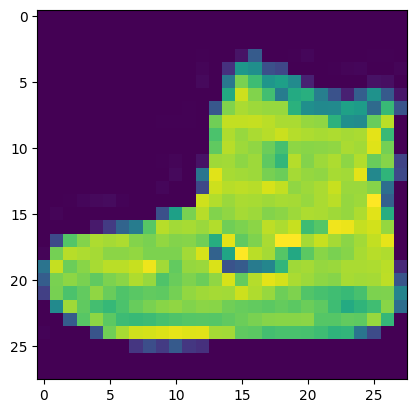

In [43]:
# 3. Let's plot the first image
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(tr_images[0])

###Perform scaling on top of the image


In [47]:
# 1. Define an object that performs scaling
from imgaug import augmenters as iaa
import numpy as np
aug = iaa.Affine(scale=2)

def to_numpy(tensor):
  return tensor.cpu().detach().numpy()

In [45]:
tr_images[0].type()

'torch.ByteTensor'

Text(0.5, 1.0, 'Scaled image')

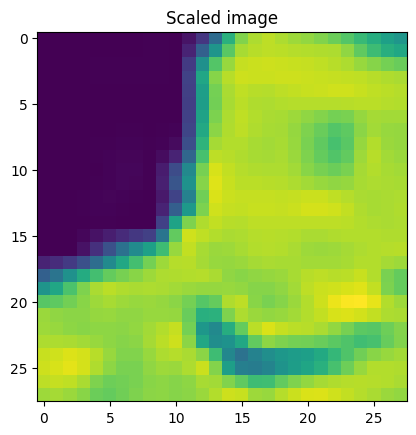

In [48]:
# Specify that we want to augment the image using the augment_image() method
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title("Scaled image")

### Now Let's look at a scenario where an image has been translated by a certain number of pixels using the `translate_px` parameter

Text(0.5, 1.0, 'Translated image by 10 pixels (right and bottom)')

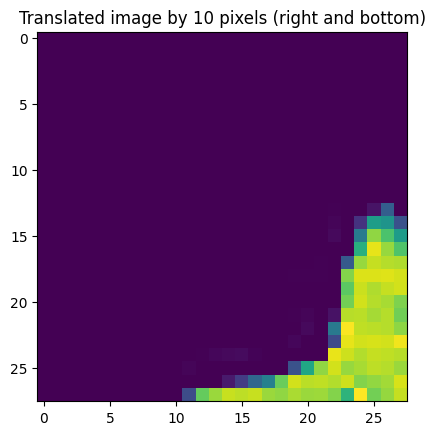

In [50]:
aug = iaa.Affine(translate_px=10)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title("Translated image by 10 pixels (right and bottom)")

## If we want to perform translation more in one axis and less in the other axis, we must specify the amount of translation we want in each axis

Here we provide a dictionary that states the amount of translation in the x and y axes in the `translate_px` parameter.

Text(0.5, 1.0, 'Translation of 10 pixels \nacross columns and 2 pixels over rows')

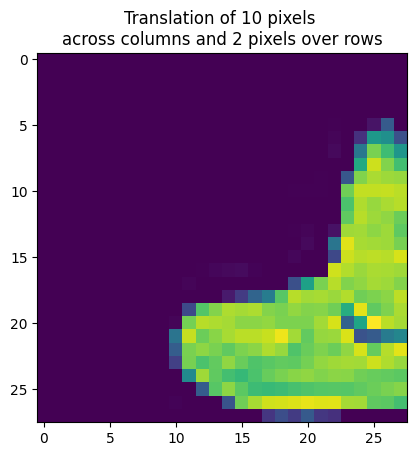

In [51]:
aug = iaa.Affine(translate_px={'x':10, 'y':2})
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title('Translation of 10 pixels \nacross columns and 2 pixels over rows')

##Now let's consider the impact of rotation and shearing on the image augmentation

Text(0.5, 1.0, 'Rotation of image by 30 degress')

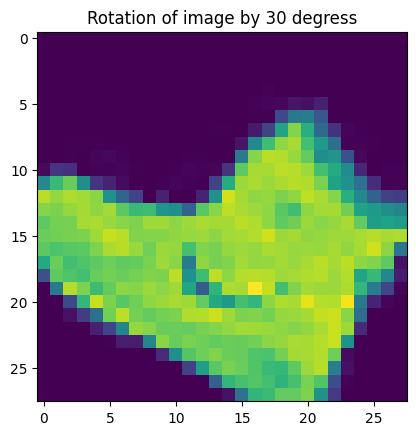

In [52]:
# Rotation by 30 degress
aug = iaa.Affine(rotate=30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title('Rotation of image by 30 degress')

Text(0.5, 1.0, 'Rotation of image by -30 degress')

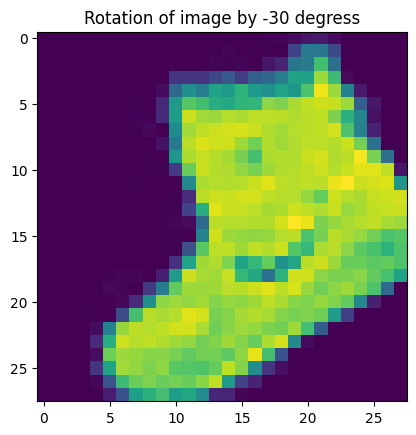

In [53]:
# Rotation by -30 degress
aug = iaa.Affine(rotate=-30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title('Rotation of image by -30 degress')

Text(0.5, 1.0, 'Shear of image by 30 degress')

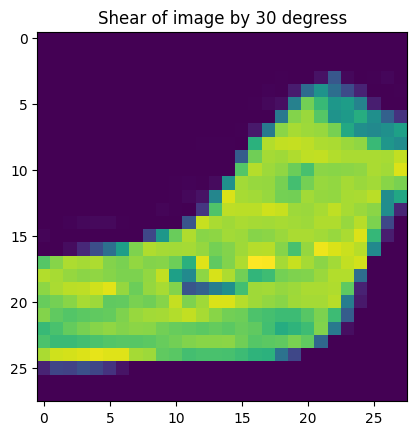

In [54]:
# Shear of image by 30 degress
aug = iaa.Affine(shear=30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title('Shear of image by 30 degress')

Text(0.5, 1.0, 'Shear of image by -30 degrees')

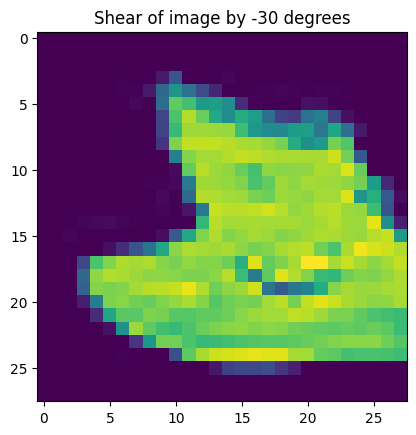

In [55]:
# shear of image by -30 degrees
aug = iaa.Affine(shear=-30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title('Shear of image by -30 degrees')

Text(0.5, 1.0, 'Shear of image\nby 30 degrees')

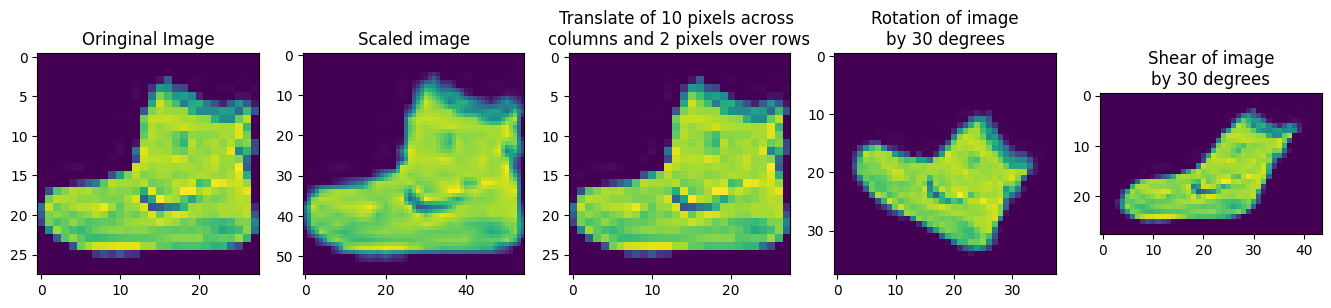

In [57]:
# Combined rotate and shear transformations with fit_output=True
plt.figure(figsize=(20, 20))
plt.subplot(161)
plt.imshow(tr_images[0])
plt.title('Oringinal Image')
plt.subplot(162)
aug =iaa.Affine(scale=2, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title('Scaled image')
plt.subplot(163)
aug = iaa.Affine(translate_px={'x':10, 'y':2}, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title('Translate of 10 pixels across \ncolumns and 2 pixels over rows')
plt.subplot(164)
aug = iaa.Affine(rotate=30, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title('Rotation of image\nby 30 degrees')
plt.subplot(165)
aug = iaa.Affine(shear=30, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title('Shear of image\nby 30 degrees')